# Classificazione Multiclasse - Albero Decisionale


In [6]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import joblib
import os

In [7]:
X_train = pd.read_csv("../data/splitted_category/X_train.csv")
X_test = pd.read_csv("../data/splitted_category/X_test.csv")
y_train = pd.read_csv("../data/splitted_category/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/splitted_category/y_test.csv").values.ravel()


In [8]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced',	random_state=42 )

model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [9]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)





def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred, average='weighted'),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_true, y_pred)
    }

train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)







In [10]:
#verifico se le classi sono sbilanciate
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(22), np.int64(1): np.int64(14), np.int64(2): np.int64(56), np.int64(3): np.int64(30), np.int64(4): np.int64(80), np.int64(5): np.int64(112), np.int64(6): np.int64(64), np.int64(7): np.int64(7), np.int64(8): np.int64(60), np.int64(9): np.int64(12), np.int64(10): np.int64(97), np.int64(11): np.int64(27), np.int64(12): np.int64(22), np.int64(13): np.int64(58), np.int64(14): np.int64(16), np.int64(15): np.int64(12), np.int64(16): np.int64(94), np.int64(17): np.int64(9)}


In [11]:
#verifico chi sto penalizzando
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.41      0.41      0.41        22
           1       0.40      0.29      0.33        14
           2       0.58      0.52      0.55        56
           3       0.19      0.20      0.20        30
           4       0.39      0.44      0.41        80
           5       0.65      0.55      0.60       112
           6       0.30      0.30      0.30        64
           7       0.67      0.29      0.40         7
           8       0.64      0.58      0.61        60
           9       1.00      0.58      0.74        12
          10       0.52      0.54      0.53        97
          11       0.23      0.19      0.20        27
          12       0.30      0.41      0.35        22
          13       0.75      0.72      0.74        58
          14       0.18      0.19      0.18        16
          15       0.10      0.25      0.15        12
          16       0.53      0.57      0.55        94
          17       0.67    

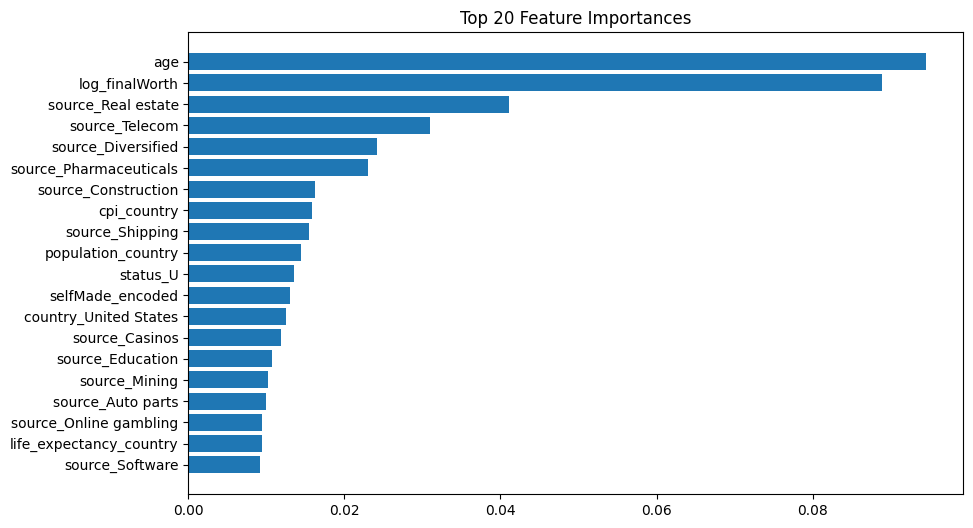

In [12]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X_train.columns
sorted_idx = importances.argsort()[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.savefig("../results/classification_category/DTdefault_top20features.png")
plt.show()


In [13]:
os.makedirs("../results/classification_category", exist_ok=True)

with open("../results/classification_category/decision_tree_metrics.txt", "w") as f:
    f.write("=== Decision Tree Classifier ===\n\n")
    
    f.write(">>> TRAIN METRICS:\n")
    for k, v in train_metrics.items():
        f.write(f"{k}: {v}\n" if k != "Confusion Matrix" else f"{k}:\n{v}\n")

    f.write("\n>>> TEST METRICS:\n")
    for k, v in test_metrics.items():
        f.write(f"{k}: {v}\n" if k != "Confusion Matrix" else f"{k}:\n{v}\n")

joblib.dump(model, "../models/decision_tree_category_model.joblib")



['../models/decision_tree_category_model.joblib']

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



param_grid = {
    'max_depth': list(range(2, 20)),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10,15,20,25,30,35,40,50,80,100],
    'min_samples_leaf': [1, 2, 5,10,15,35,55,75,110,150]
}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1_weighted',
    cv=5,
    verbose=1,
    n_jobs=-1
)

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Migliori iperparametri trovati:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


KeyboardInterrupt: 